In [1]:
import geopandas
import pandas as pd
import numpy as np
import seaborn
from shapely.geometry import Point
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def read_farm_survey(fpath = 'data/2016_to_2020_ICS_data_v3_-_MP.xlsx'):
    def parse_coords(X):
        x, y = X['Longitude'], X['Latitude']
        if (x == np.nan) | (y == np.nan):
            return np.nan
        return Point([x,y])
            
    df = pd.read_excel(fpath)
    return geopandas.GeoDataFrame(df, geometry = df.apply(parse_coords, 1))

def read_districts(fpath = 'data/geospatial/india_districts.shp'):
    df = geopandas.read_file(fpath).set_index('objectid')
    df['District'] = df.distname.astype(str)
    return df

# load the farm survey dataset and districts shapefile
districts = read_districts()
farms = read_farm_survey()
# calculate yield
farms['yield'] = farms['Estimated yield (MT)'] / farms['Area (HA)']
farms['yield'] = farms['yield'].where(farms['yield'] < 100000)

## 1. Distribution of Records in the Dataset

In [2]:
farms.groupby('Crops').count().sort_values(['yield'])[-20:]['Year']

Crops
Brinjal               41
Blackgram             47
Sesame                47
Vacant               114
Maize                 57
Ridge Gourd           57
Sunflower             62
Onion                 66
Urad                  64
Jowar                 80
Banana                72
Tomato                97
Paddy-Sona Masuri     97
Foxtile Millet       103
Foxtail Millet       156
Green Gram           182
Non-Basmati Paddy    247
Red Gram             500
Groundnut            843
Paddy                972
Name: Year, dtype: int64

Text(0.5, 1.0, 'Top 20 records by crop type')

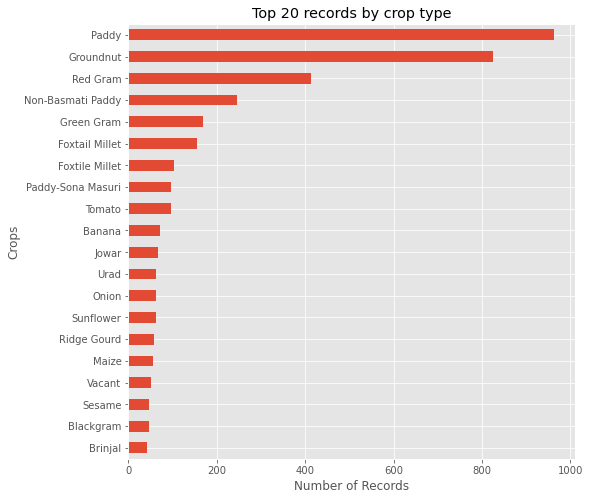

In [3]:
_, a = plt.subplots(figsize=(8,8))
farms.groupby('Crops').count().sort_values(['yield'])['yield'][-20:].plot.barh(ax=a)
plt.xlabel('Number of Records')
plt.title('Top 20 records by crop type')

## 2. Paddy Crop Yield by District

Text(0.5, 1.0, 'Paddy Crop Yield by District')

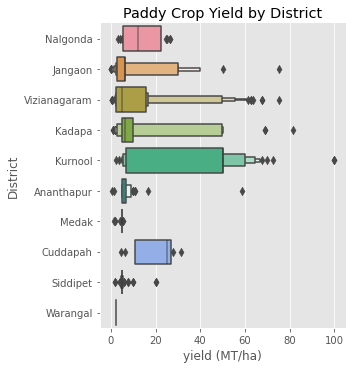

In [4]:
seaborn.catplot(data=farms.where(farms.Crops == 'Paddy'), y='District', x='yield',kind='boxen')
plt.xlabel('yield (MT/ha)')
plt.title('Paddy Crop Yield by District')

## 3. Mapping Locations of Records

Text(70.46807452225289, 0.5, 'lat')

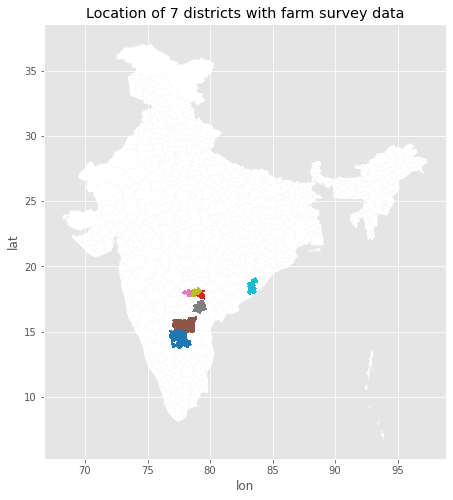

In [5]:
# join on District Name to change geometry to district polygon
farms_districts = geopandas.GeoDataFrame(farms.set_index('District').join(districts.set_index('District'),
                                     lsuffix='_District'), geometry='geometry').reset_index(drop=False)

# plot a map of the districts with data
f, a = plt.subplots(figsize=(8,8))
districts.plot(facecolor='w', ax=a)
farms_districts.plot(column='District', ax=a)
plt.title('Location of 7 districts with farm survey data')
plt.xlabel('lon')
plt.ylabel('lat')